In [1]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import pickle
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
#dics = pickle.load(open('../CellStateNN_20230712.pkl','rb'))
dics = pickle.load(open('CellStateNN_20240528.pkl','rb'))

In [124]:
palette = {
    'Astrocyte':'#038aff',
    'Oligodendrocyte':'#392e4a',
    #'GW-like 2': '#EDE8F3',
    #'GW-like 3': '#E2D8EA',
    #'GW-like Periphery1': '#D6BEDD',
    'GW-like Periphery2': '#D6BEDD',
    'GW-like Periphery3': '#D6BEDD',
    'GW-like Endo.Ass.': '#D6BEDD',
    #'GW-like 5': '#CFA8D1',
    #'GW-like 7': '#e43c96',
    'GW-like HYPR2': '#C50F53',
    #'GW-like 4': '#A40447',
    'GW-like HYPR1': '#840034',
    #'nIPC-like 3':'#dadfe1',#
    'AC-like 3':'#2ecc71',#
    'RG-like':'#ff9470',
    #'AC-like 4':'#2ecc71',#inchworm B4FF9F
    #'AC-like 5':'#2ecc71',#'#2ecc71',#inchworm B4FF9F
    #'AC-like 5':'#2ecc71',#'#2ecc71',#inchworm B4FF9F
    'preOPC-like 1':'#7befb2',#'#7befb2',#'#c2f970'
    'OPC-like 2':'#89c4f4',#'#7befb2',#'#c2f970'
    'OPC-like 1':'#89c4f4',#'#7befb2',#'#c2f970'

    #'Endothelial':'#d5b8ff', #mauve
    #'Mural': '#8c14fc',  #electric indigo
    'Endothelial': '#8c14fc',  #electric indigo
    'Mural cell': '#8c14fc',  #electric indigo
    
    'Mono 1': '#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#FBFCFA',
    
    'TAM-BDM 3':'#e8ecf1',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#dd9f57',#'#A5765C',
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    

}


In [125]:
samples = list(dics.keys())

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 25, 36, 37, 38, 39, 40, 42, 43, 48, 50, 51, 53, 55, 58, 60, 68, 70, 71, 72, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87, 92, 3228]
INFO:fontTools.subset:Closed glyph list 

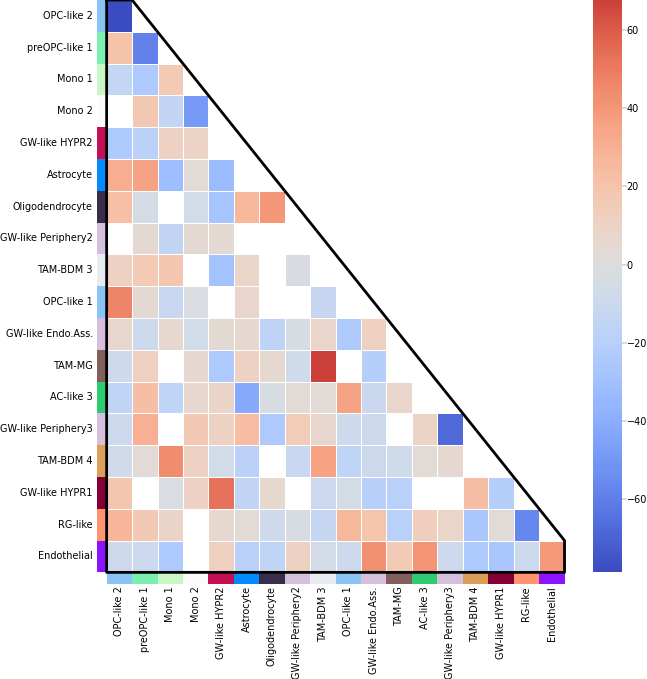

Index(['OPC-like 2', 'preOPC-like 1', 'Mono 1', 'Mono 2', 'GW-like HYPR2',
       'Astrocyte', 'Oligodendrocyte', 'GW-like Periphery2', 'TAM-BDM 3',
       'OPC-like 1', 'GW-like Endo.Ass.', 'TAM-MG', 'AC-like 3',
       'GW-like Periphery3', 'TAM-BDM 4', 'GW-like HYPR1', 'RG-like',
       'Endothelial'],
      dtype='object')

In [126]:

from sklearn.preprocessing import StandardScaler
classes0 = list(palette.keys())
classes0 = np.array(classes0)
classes = []
for s in dics:
    classes += dics[s].index.tolist()
classes = np.unique(np.array(classes))
classes = classes0[np.isin(classes0, classes)]
df0 = dics[list(dics.keys())[0]]
df0 = df0.loc[classes][classes]
vals = np.zeros_like(df0.values)

for x in samples:
    df = dics[x] 
    df = df.loc[classes][classes]
    samples = list(dics.keys())
    df.replace([np.inf, -np.inf], 0, inplace=True)
    X = StandardScaler().fit_transform(df.values)
    X = StandardScaler().fit_transform(X.T).T
    #X = df.values
    vals += X

NN_MES = pd.DataFrame(data=vals, columns=classes, index = classes)

sp.pl.neighborhood_enrichment_from_pandas(
    NN_MES,
    palette=palette,
    save=True,
    #order_cols=order,
    #order_rows=order,
    figsize=(7,7),
    savepath=f'figures/NN_Immune.pdf',
    
)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 20, 21, 22, 23, 36, 37, 38, 39, 40, 42, 43, 48, 50, 51, 53, 55, 58, 60, 68, 70, 71, 72, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 40 glyphs after
INFO:font

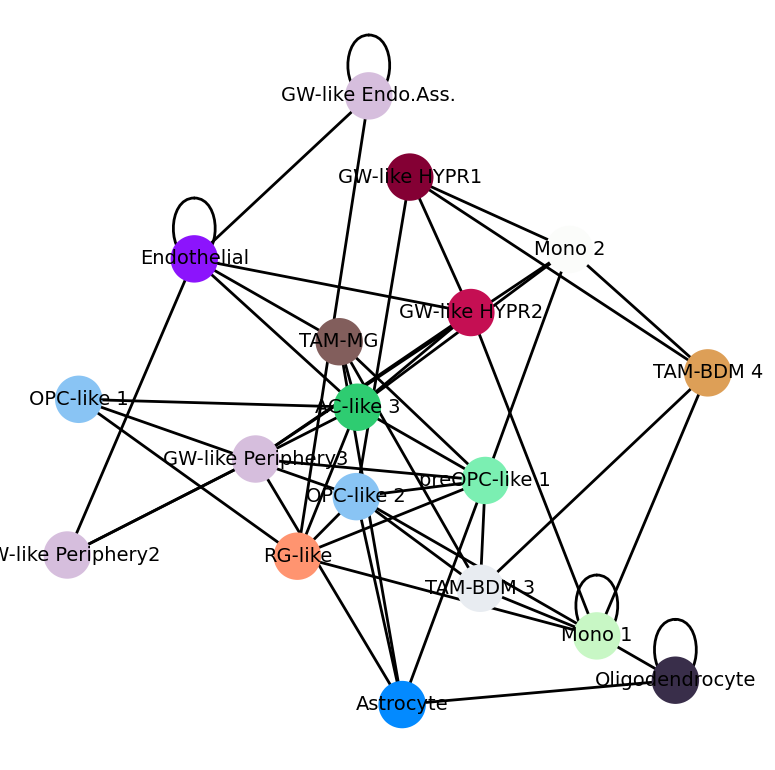

In [130]:
import networkx as nx
np.random.seed(12345)
df = NN_MES
df = df.melt(ignore_index=False)
df = df[df.value > 10.5]
df['X'] = df.index
df['Y'] = df.variable
# Transform it in a links data frame (3 columns only):
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
G=nx.from_pandas_edgelist(df, 'X', 'Y')


# Plot the network:
nx.draw_networkx(
    G, 
    with_labels=True,
    node_color=[palette[n] for n in G.nodes()], 
    node_size=200, 
    edge_color='black',
    width=2,
    linewidths=20, 
    font_size=14,
    font_family='Arial',
    pos=nx.spring_layout(G,k=1.5),
    #kwargs={'edgecolor':'black'}
)
plt.axis('off')
plt.savefig(f'figures/ImmuneGraph.pdf', transparent=True)



# SL001B

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsi

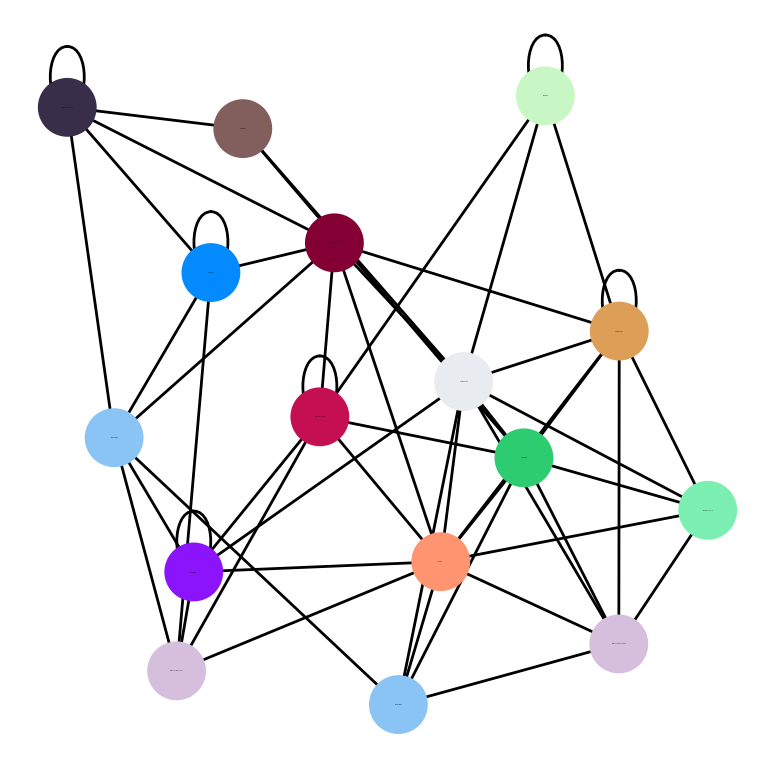

In [145]:
samples = ['SL001B']
from sklearn.preprocessing import StandardScaler
classes0 = list(palette.keys())
classes0 = np.array(classes0)
classes = []
for s in dics:
    classes += dics[s].index.tolist()
classes = np.unique(np.array(classes))
classes = classes0[np.isin(classes0, classes)]
df0 = dics[list(dics.keys())[0]]
df0 = df0.loc[classes][classes]
vals = np.zeros_like(df0.values)

for x in samples:
    df = dics[x] 
    df = df.loc[classes][classes]
    #samples = list(dics.keys())
    df.replace([np.inf, -np.inf], 0, inplace=True)
    #X = StandardScaler().fit_transform(df.values)
    #X = StandardScaler().fit_transform(X.T).T
    X = df.values
    vals += X

NN_MES = pd.DataFrame(data=vals, columns=classes, index = classes)

'''sp.pl.neighborhood_enrichment_from_pandas(
    NN_MES,
    palette=palette,
    save=True,
    #order_cols=order,
    #order_rows=order,
    figsize=(7,7),
    savepath='figures/NN_Immune{}.pdf'.format(samples[0]),
    
)'''

import networkx as nx
df = NN_MES
df = df.melt(ignore_index=False)
df = df[df.value > .5]
df['X'] = df.index
df['Y'] = df.variable
# Transform it in a links data frame (3 columns only):
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
G=nx.from_pandas_edgelist(df, 'X', 'Y')


# Plot the network:
nx.draw_networkx(
    G, 
    with_labels=True,
    node_color=[palette[n] for n in G.nodes()], 
    node_size=500, 
    edge_color='black',
    width=2,
    linewidths=20, 
    font_size=0,
    font_family='Arial',
    pos=nx.spring_layout(G,k=1),
    #kwargs={'edgecolor':'black'}
)
plt.axis('off')
plt.savefig('figures/ImmuneGraph{}.pdf'.format(samples[0]), transparent=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 36, 37, 38, 39, 40, 42, 43, 48, 50, 51, 53, 55, 58, 60, 68, 70, 71, 72, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87, 92, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB'

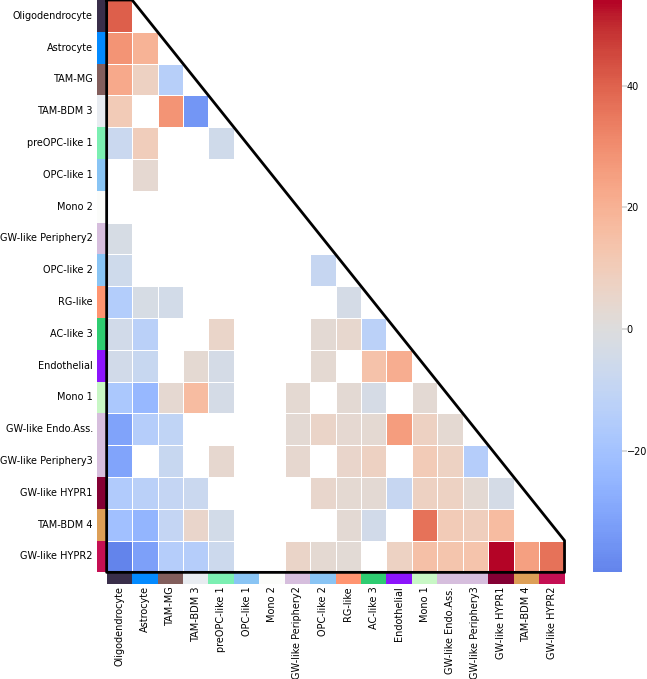

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsi

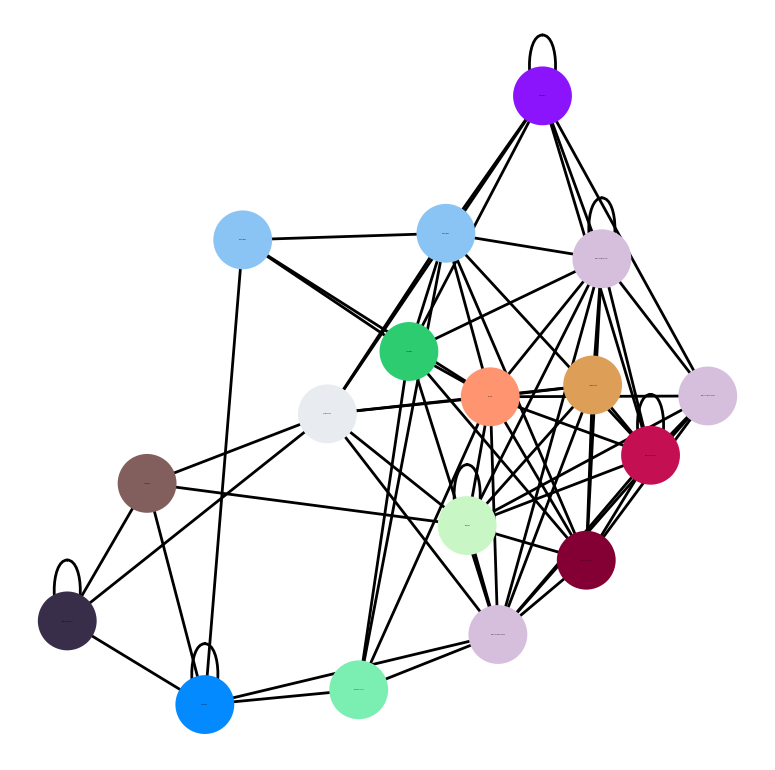

In [140]:
samples = ['SL046C']

from sklearn.preprocessing import StandardScaler
classes0 = list(palette.keys())
classes0 = np.array(classes0)
classes = []
for s in dics:
    classes += dics[s].index.tolist()
classes = np.unique(np.array(classes))
classes = classes0[np.isin(classes0, classes)]
df0 = dics[list(dics.keys())[0]]
df0 = df0.loc[classes][classes]
vals = np.zeros_like(df0.values)

for x in samples:
    df = dics[x] 
    df = df.loc[classes][classes]
    #samples = list(dics.keys())
    df.replace([np.inf, -np.inf], 0, inplace=True)
    #X = StandardScaler().fit_transform(df.values)
    #X = StandardScaler().fit_transform(X.T).T
    X = df.values
    vals += X

NN_MES = pd.DataFrame(data=vals, columns=classes, index = classes)

sp.pl.neighborhood_enrichment_from_pandas(
    NN_MES,
    palette=palette,
    save=True,
    #order_cols=order,
    #order_rows=order,
    figsize=(7,7),
    savepath='figures/NN_Immune{}.pdf'.format(samples[0]),
    
)

import networkx as nx
df = NN_MES
df = df.melt(ignore_index=False)
df = df[df.value > .5]
df['X'] = df.index
df['Y'] = df.variable
# Transform it in a links data frame (3 columns only):
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
G=nx.from_pandas_edgelist(df, 'X', 'Y')


# Plot the network:
nx.draw_networkx(
    G, 
    with_labels=True,
    node_color=[palette[n] for n in G.nodes()], 
    node_size=500, 
    edge_color='black',
    width=2,
    linewidths=20, 
    font_size=0,
    #font_family='Arial',
    pos=nx.spring_layout(G,k=1),
    #kwargs={'edgecolor':'black'}
)
plt.axis('off')
plt.savefig('figures/ImmuneGraph{}.pdf'.format(samples[0]), transparent=True)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsi

SL061B


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subs

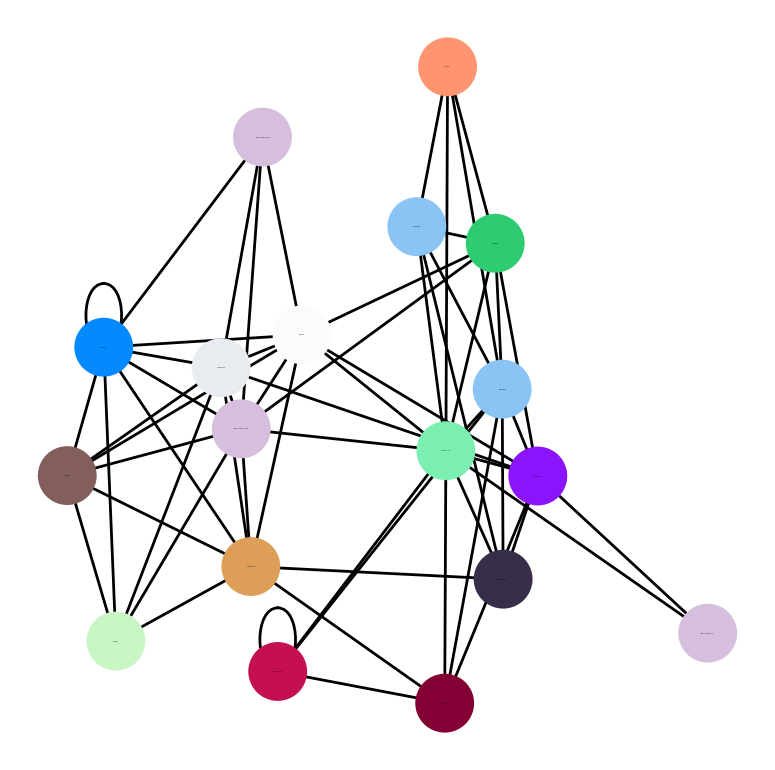

In [171]:
#for x in np.arange(10):
print(x)
np.random.seed(7)
samples = ['SL061B']

from sklearn.preprocessing import StandardScaler
classes0 = list(palette.keys())
classes0 = np.array(classes0)
classes = []
for s in dics:
    classes += dics[s].index.tolist()
classes = np.unique(np.array(classes))
classes = classes0[np.isin(classes0, classes)]
df0 = dics[list(dics.keys())[0]]
df0 = df0.loc[classes][classes]
vals = np.zeros_like(df0.values)

for x in samples:
    df = dics[x] 
    df = df.loc[classes][classes]
    #samples = list(dics.keys())
    df.replace([np.inf, -np.inf], 0, inplace=True)
    #X = StandardScaler().fit_transform(df.values)
    #X = StandardScaler().fit_transform(X.T).T
    X = df.values
    vals += X

NN_MES = pd.DataFrame(data=vals, columns=classes, index = classes)
import networkx as nx
df = NN_MES
df = df.melt(ignore_index=False)
df = df[df.value > .5]
df['X'] = df.index
df['Y'] = df.variable
# Transform it in a links data frame (3 columns only):
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
G=nx.from_pandas_edgelist(df, 'X', 'Y')


# Plot the network:
nx.draw_networkx(
    G, 
    with_labels=True,
    node_color=[palette[n] for n in G.nodes()], 
    node_size=500, 
    edge_color='black',
    width=2,
    linewidths=20, 
    font_size=0,
    #font_family='Arial',
    pos=nx.spring_layout(G,k=1),
    #kwargs={'edgecolor':'black'}
)
plt.axis('off')
plt.savefig('figures/ImmuneGraph{}.pdf'.format(samples[0]), transparent=True)

In [174]:
df

,variable,value,X,Y
Astrocyte,Astrocyte,43.962697,Astrocyte,Astrocyte
Oligodendrocyte,Astrocyte,90.564845,Oligodendrocyte,Astrocyte
AC-like 3,Astrocyte,18.182235,AC-like 3,Astrocyte
RG-like,Astrocyte,5.319693,RG-like,Astrocyte
preOPC-like 1,Astrocyte,22.440482,preOPC-like 1,Astrocyte
...,...,...,...,...
Oligodendrocyte,TAM-MG,33.099376,Oligodendrocyte,TAM-MG
AC-like 3,TAM-MG,14.973869,AC-like 3,TAM-MG
preOPC-like 1,TAM-MG,8.044297,preOPC-like 1,TAM-MG
Mono 1,TAM-MG,2.808238,Mono 1,TAM-MG


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsi

1


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 20, 21, 22, 23, 36, 37, 38, 39, 40, 42, 43, 48, 50, 51, 53, 55, 58, 60, 68, 70, 71, 72, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 40 glyphs after
INFO:font

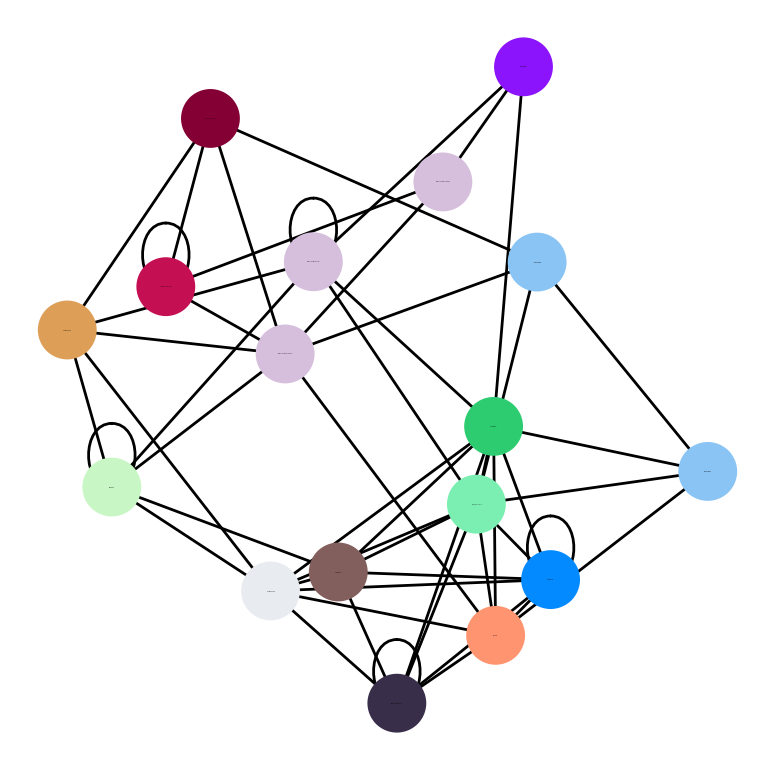

In [175]:
samples = ['SL035B']

#for x in range(10):
print(1)
np.random.seed(1)
from sklearn.preprocessing import StandardScaler
classes0 = list(palette.keys())
classes0 = np.array(classes0)
classes = []
for s in dics:
    classes += dics[s].index.tolist()
classes = np.unique(np.array(classes))
classes = classes0[np.isin(classes0, classes)]
df0 = dics[list(dics.keys())[0]]
df0 = df0.loc[classes][classes]
vals = np.zeros_like(df0.values)

for x in samples:
    df = dics[x] 
    df = df.loc[classes][classes]
    #samples = list(dics.keys())
    df.replace([np.inf, -np.inf], 0, inplace=True)
    #X = StandardScaler().fit_transform(df.values)
    #X = StandardScaler().fit_transform(X.T).T
    X = df.values
    vals += X

NN_MES = pd.DataFrame(data=vals, columns=classes, index = classes)

'''sp.pl.neighborhood_enrichment_from_pandas(
    NN_MES,
    palette=palette,
    save=True,
    #order_cols=order,
    #order_rows=order,
    figsize=(7,7),
    savepath='figures/NN_Immune{}.pdf'.format(samples[0]),

)
'''
import networkx as nx
df = NN_MES
df = df.melt(ignore_index=False)
df = df[df.value > 2.5]
df['X'] = df.index
df['Y'] = df.variable
# Transform it in a links data frame (3 columns only):
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
G=nx.from_pandas_edgelist(df, 'X', 'Y')


# Plot the network:
nx.draw_networkx(
    G, 
    with_labels=True,
    node_color=[palette[n] for n in G.nodes()], 
    node_size=500, 
    edge_color='black',
    width=2,
    linewidths=20, 
    font_size=0,
    font_family='Arial',
    pos=nx.spring_layout(G,k=1),
    #kwargs={'edgecolor':'black'}
)
plt.axis('off')
plt.savefig('figures/ImmuneGraph{}.pdf'.format(samples[0]), transparent=True)
plt.show()